# Assignemnt 3
Sigvard Bratlie

In [3]:
import pandas as pd
import requests
import matplotlib.pyplot as plt

## Fetch data

In [52]:
def mk_request(url: str,params: dict = None):
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        return data
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return None

#Function for the API download
def get_weather(lat : float , lon:float, year : int, ):
    params = {"latitude" : lat, "longitude": lon, 
              "start_date": f"{year}-01-01",
              "end_date": f"{year}-12-31",
              "hourly": "temperature_2m,precipitation_spread,wind_speed_10m,wind_gusts_10m_spread,wind_direction_10m",
              "models" : "era5"
              }
    base_url = "https://archive-api.open-meteo.com/v1/archive?"
    return mk_request(base_url,params=params)

### Geocoding

Oslo, Kristiansand, Trondheim, Tromsø and Bergen

* Østlandet (NO1) 
* Sørvest-Norge (NO2) 
* Midt-Norge (NO3) 
* Nord-Norge (NO4)  
* Vestlandet (NO5) 

In [53]:
def geocode(city : str):
    url = f"https://geocoding-api.open-meteo.com/v1/search?name={city}&count=10&language=en&format=json"
    return mk_request(url)

def get_coor(city: str):
    res = geocode(city).get("results")[0]
    lat, lon = res.get("latitude"), res.get("longitude")
    return lat, lon

In [54]:
cities = {"Oslo" : "NO1", 
          "Kristiansand" : "NO2", 
          "Trondheim" : "NO3", 
          "Tromsø" : "NO4", 
          "Bergen" : "NO5"}
geocoded_cities = {}
for city,price_area in cities.items():
    lat, lon = get_coor(city)
    geocoded_cities[city] = (lat, lon,price_area)

cities_df = pd.DataFrame.from_dict(geocoded_cities, orient="index", columns=["latitude", "longitude", "price_area"])
cities_df

,latitude,longitude,price_area
Oslo,59.91273,10.74609,NO1
Kristiansand,58.14671,7.99560,NO2
Trondheim,63.43049,10.39506,NO3
Tromsø,69.64890,18.95508,NO4
Bergen,60.39299,5.32415,NO5


### Weather data for Bergen

In [55]:
lat,lon = get_coor("Bergen")
data = get_weather(lat, lon, 2019)

In [56]:
data

{'latitude': 60.5,
 'longitude': 5.25,
 'generationtime_ms': 2.4309158325195312,
 'utc_offset_seconds': 0,
 'timezone': 'GMT',
 'timezone_abbreviation': 'GMT',
 'elevation': 17.0,
 'hourly_units': {'time': 'iso8601',
  'temperature_2m': '°C',
  'precipitation_spread': 'mm',
  'wind_speed_10m': 'km/h',
  'wind_gusts_10m_spread': 'km/h',
  'wind_direction_10m': '°'},
 'hourly': {'time': ['2019-01-01T00:00',
   '2019-01-01T01:00',
   '2019-01-01T02:00',
   '2019-01-01T03:00',
   '2019-01-01T04:00',
   '2019-01-01T05:00',
   '2019-01-01T06:00',
   '2019-01-01T07:00',
   '2019-01-01T08:00',
   '2019-01-01T09:00',
   '2019-01-01T10:00',
   '2019-01-01T11:00',
   '2019-01-01T12:00',
   '2019-01-01T13:00',
   '2019-01-01T14:00',
   '2019-01-01T15:00',
   '2019-01-01T16:00',
   '2019-01-01T17:00',
   '2019-01-01T18:00',
   '2019-01-01T19:00',
   '2019-01-01T20:00',
   '2019-01-01T21:00',
   '2019-01-01T22:00',
   '2019-01-01T23:00',
   '2019-01-02T00:00',
   '2019-01-02T01:00',
   '2019-01-02T0

## Outliers and anomalies

In [59]:
df = pd.DataFrame(data.get("hourly"))
df["time"] = pd.to_datetime(df["time"])
df.set_index("time", inplace=True)
df.head()

,temperature_2m,precipitation_spread,wind_speed_10m,wind_gusts_10m_spread,wind_direction_10m
time,,,,,
2019-01-01 00:00:00,6.6,0.1,48.0,5.0,278
2019-01-01 01:00:00,6.8,0.2,48.6,5.4,296
2019-01-01 02:00:00,6.8,0.2,52.6,5.8,310
2019-01-01 03:00:00,6.6,0.2,55.8,6.1,314
2019-01-01 04:00:00,6.2,0.1,55.5,5.8,317


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2019-01-01 00:00:00 to 2019-12-31 23:00:00
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   temperature_2m         8760 non-null   float64
 1   precipitation_spread   8760 non-null   float64
 2   wind_speed_10m         8760 non-null   float64
 3   wind_gusts_10m_spread  8760 non-null   float64
 4   wind_direction_10m     8760 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 410.6 KB


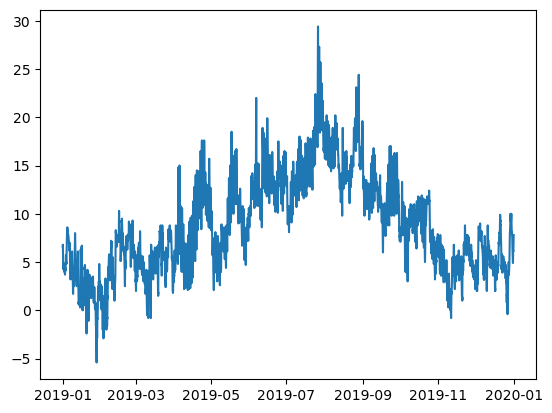

In [61]:
plt.plot(df.index, df["temperature_2m"])